# 1. Packages

In [1]:
# --- Core data handling
import pandas as pd 
import numpy as np 
import pyarrow

# --- Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import FuncFormatter
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go 

# --- Statistics and Modeling
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- File I/O & utilities
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# 2. Data information

In [2]:
df = pd.read_csv (r"C:\Users\juand\OneDrive\Escritorio\github_projects\ICE-Video-Game\datasets\games.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# 3. Data cleaning and preparation

In [3]:
# Columns standarization and cleaning
df.columns = df.columns.str.strip().str.lower()

# Convert release year to integer, keeping NaN for missing entries
df["year_of_release"] = (
    pd.to_numeric (df["year_of_release"], errors="coerce")
    .astype ("Int64")
)

# Replace "tbd" with NaN and convert user_score to numeric
us = df["user_score"].astype("str").str.strip().str.lower()
us = us.replace ({"tbd":np.nan})
df["user_score"] = pd.to_numeric (us, errors="coerce")

# Replace NaN in rating with "unknown"
df["rating"] = df["rating"].replace (np.nan, "unknown")
df["rating"] = df["rating"].replace ("rp", "unknown")

# Boolean indicators for critic and user score 
df["critic_score_missing"] = df["critic_score"].isna()
df["user_score_missing"] = df["user_score"].isna()

# Remove games without name and genre 
df = df.dropna (subset = ["name", "genre"])

# Removing missing values in year_of_release 
df = df.dropna (subset= ["year_of_release"]) 

# Remove duplicates based on name and platform, keeping the first occurrence 
df = df.drop_duplicates (subset = ["name", "platform"], keep= "first")

# Remove outlier value for DS platform since it doesn't make sense
df = df[~((df["platform"] == "DS") & (df["year_of_release"] < 2004))]

# Align critic_score with user_score 
df["critic_score"] = df["critic_score"]/10

# Columns content standarization and cleaning
df["platform"] = df["platform"].str.strip().str.upper().astype("category")

standarize = ["genre", "rating"]
for column in standarize: 
    df[column] = (
        df[column].astype (str)
        .str.strip().str.lower()
        .astype ("category")
    )

# Create a new column for total sales 
df["total_sales"] = df[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum(axis=1)

# Drop rows with no sells 
df = df[df["total_sales"] != 0].copy()

# 3. EDA

In [4]:
sales_by_year = (
    df.groupby ("year_of_release", as_index = False)
    .agg (sales = ("total_sales", "sum"), games_count = ("name", "count"))
)

Text(0, 0.5, 'Market Revenue (USD)')

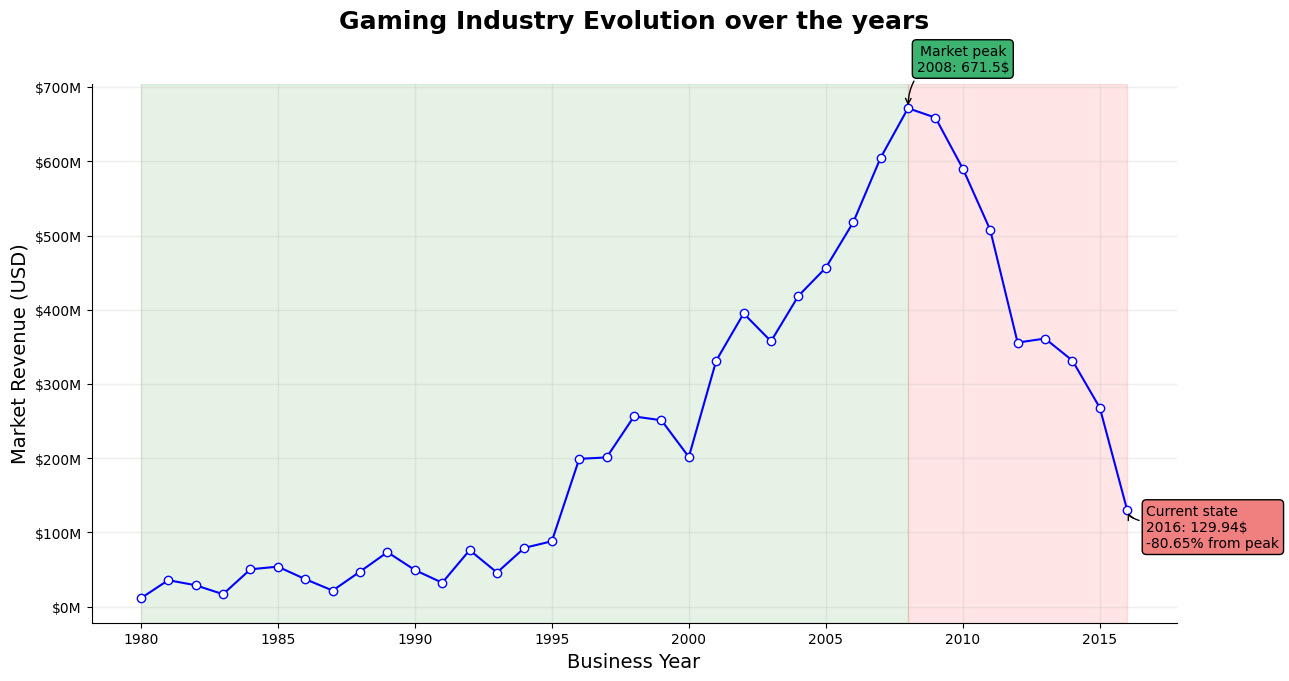

In [5]:
# Max values
peak_idx = sales_by_year["sales"].idxmax()
peak_year = sales_by_year.loc [peak_idx, "year_of_release"]
peak_value = sales_by_year.loc [peak_idx, "sales"]

# Initial values 
first_year = sales_by_year["year_of_release"].iloc [0]
first_value = sales_by_year["year_of_release"].iloc [0]

# Latest values 
last_year = sales_by_year["year_of_release"].iloc[-1]
last_value = sales_by_year["sales"].iloc[-1]

# Decrease from peak 
d_percent = round (100 - (last_value * 100 / peak_value), 2)

# Main plot
plt.figure(figsize = (14,7))
sns.lineplot (
    data = sales_by_year, 
    x = "year_of_release", 
    y = "sales", 
    marker = "o", 
    color = "blue",
    markerfacecolor = "white", 
    markeredgecolor = "blue", 
    markeredgewidth = 1
)
plt.grid (True, linewidth = 1, alpha = 0.2, linestyle = "-")

# Remove right and top spines
ax = plt.gca ()
rm_spines = ["top", "right"]
for e in rm_spines: 
    ax.spines[e].set_visible (False)


# Annotations
plt.annotate (
    text = f"Market peak\n{peak_year}: {peak_value}$",
    xy = (peak_year, peak_value), 
    xytext = (peak_year + 2, peak_value + 50),
    bbox = dict(boxstyle = "round", fc = "mediumseagreen"), 
    arrowprops = dict(arrowstyle = "->", connectionstyle = "angle3,angleA=0,angleB=-90"),
    ha = "center"
)

plt.annotate (
    xy = (last_year, last_value), 
    xytext = (last_year + 0.7, last_value - 50), 
    text = f"Current state\n{last_year}: {last_value}$\n-{d_percent}% from peak",
    bbox = dict (boxstyle = "round", fc = "lightcoral"), 
    arrowprops = dict(arrowstyle = "->", connectionstyle = "angle3,angleA=0,angleB=-90")
)

# Shadding 
plt.axvspan (first_year, peak_year, color = "green", alpha = 0.1)
plt.axvspan (peak_year, last_year, color = "red", alpha = 0.1)
plt.gca ().yaxis.set_major_formatter (FuncFormatter(lambda x,_: f"${x:,.0f}M"))

# Title and labels
plt.title ("Gaming Industry Evolution over the years", fontsize = 18, weight = "bold" ,pad = 40)
plt.xlabel ("Business Year", fontsize = 14)
plt.ylabel ("Market Revenue (USD)", fontsize = 14)
